<div style="text-align:center"> 
        <strong style="font-size:30px;"> <br> Deep Learning <br><br>  Transfert de style d'images (Pistes d'extension)<br> 
</strong> 
    <br><br>   
Auteurs : Paul-Antoine Inghelbrecht, Joël Hamilcaro, Jie Tu <br><br>
18 février 2022
</div>


**Objectifs :**

En guise d'extension, nous allons essayer d'implémenter de deux autres méthodes de transfert de style d'image. La première est une architecture spécialisée dans un seul style (qu'il pourra transférer à n'importe quelle image). Il s'agit du modèle cité dans l'article de [Johnson, Alahi et Fei-Fei](https://arxiv.org/abs/1603.08155). La seconde est une architecture qui, en une seule étape d'entraînement, s'adapte à tout type de transfert : c'est l'"Arbitrary Style Transfert", décrit notamment dans les papiers de [Huang](https://arxiv.org/abs/1703.06868) et [Ghiasi](https://arxiv.org/abs/1705.06830). Ces deux méthodes correspondent aux architectures **(2)** et **(3)** que nous avons décrit en préambule dans l'*Abstract* du notebook `1_Projet_HAMILCARO_TU_INGHELBRECHT.ipypnb`. 

Dans ce notebook on présente nos pistes de recherche.

## « Perceptual Losses for Real-Time Style Transfer and Super-Resolution » 

Nous allons utiliser un modèle  un modèle pré-entraîné (CNN), et à partir de celui-ci, créer un modèle qui sera lié a un seul style. C’est-à-dire qu’il n’y aura pas de possibilité de choisir le style entre chaque image. 

Ce modèle est composé de deux réseaux :

- l’image de contenu va être transformée en plusieurs "features", modifiée puis recréée avec le nouveau style. La structure du modèle est différente, utilisant un VGG16 et modifiant certaines couches afin d’obtenir de meilleurs résultats (Papier de [Radford](https://arxiv.org/abs/1511.06434)). 

- Le calcul de perte sera basé sur la « Perception Loss » qui est comparable à la Total Loss.

Pour ce modèle, le temps de calcul est plus élevé, car il faut entraîner le réseau avec le style sur une base de données images importantes. Mais une fois le modèle entraîné avec le style, le transfert est rapide.


### Import de l'architecture 

Nous avons donc importer l'architecture déjà implémentée sur ce repertoire GitHub : https://github.com/pytorch/examples/tree/master/fast_neural_style

Nous avons quand même cherché à modifier l'architecture en utilisant un modèle VGG19.

In [1]:
if 'google.colab' in str(get_ipython()):
    in_colab = True
    from google.colab import drive
    drive.mount('/content/drive')
    path = "drive/MyDrive/projetDL/" # modify if needed 
else:
    in_colab = False
    path = "./projetDL-20220214T145006Z-001/projetDL/" # modify if needed 

In [2]:
import time 
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook
from collections import namedtuple

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:

class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(
            128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(
            64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(
                mode='nearest', scale_factor=upsample)
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = self.upsample_layer(x_in)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [4]:
LossOutput = namedtuple(
    "LossOutput", ["relu1", "relu2", "relu3", "relu4", "relu5"])

class LossNetwork(torch.nn.Module):
    """Reference:
        https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
    """

    def __init__(self):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg.vgg19(pretrained=True).features
        self.layer_name_mapping = {
            '3': "relu1",
            '8': "relu2",
            '17': "relu3",
            '26': "relu4",
            '35': "relu5",
        }

    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

Le modèle NetTransfer va prendre une image en entrée et la transformer en un output. Les points des couches du réseau seront appris en fonction des calculs de loss et du transfer de style.

Le modèle LossNetwork utilise un modèle pré-entraîné VGG19. On va lui indiquer les couches qui vont en particulier le contenu ou le style d'une image.

In [5]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std

def recover_image(img):
    return (
        (
            img *
            np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) +
            np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
        ).transpose(0, 2, 3, 1) *
        255.
    ).clip(0, 255).astype(np.uint8)

In [6]:
#DATASET = path
transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])
train_dataset = datasets.ImageFolder("./dataset/", transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    loss_network = LossNetwork()
    loss_network.to(device)
loss_network.eval()

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [8]:
STYLE_IMAGE = path+"style/style_12.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
with torch.no_grad():
    style_img_tensor = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])]
    )(style_img).unsqueeze(0)
    style_img_tensor = style_img_tensor.to(device)

Voici l'image de style sur lequel nous allons créer un modèle :

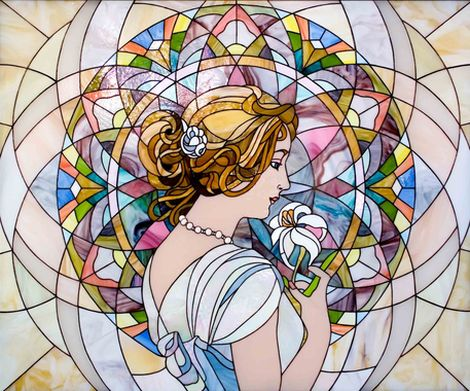

In [9]:
with torch.no_grad():
    style_loss_features = loss_network(style_img_tensor)
    gram_style = [gram_matrix(y) for y in style_loss_features]

In [10]:
style_loss_features._fields

('relu1', 'relu2', 'relu3', 'relu4', 'relu5')

In [11]:
transformer = TransformerNet().to(device)
mse_loss = torch.nn.MSELoss()
optimizer = Adam(transformer.parameters(), 0.1)

In [12]:
torch.set_default_tensor_type('torch.FloatTensor')
   
def train(steps):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    agg_stable_loss = 0.
    while True:
        for x, _ in train_loader:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = transformer(x)     
            y = normalize_batch(y)
            x = normalize_batch(x)    
            
            features_y = loss_network(y)
            features_x = loss_network(x)
            
            content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], features_x[2])

            style_loss = 0.
            for l, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss

            if count % LOG_INTERVAL == 0:
                mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  total: {:.6f}".format(
                            time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss) / LOG_INTERVAL)
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                transformer.eval()
                transformer.train()

            if count >= steps:
                
                transformer.eval().cpu()
                save_model_filename = "m1.model"
                save_model_path = os.path.join("./models", save_model_filename)
                torch.save(transformer.state_dict(), save_model_path)
                return

In [13]:
CONTENT_WEIGHT = 1
#STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 5e3
STYLE_WEIGHTS = np.array([1, 1, 1, 1, 1]) * 1e6
LOG_INTERVAL = 50

In [14]:
train(3000)

Sun Feb 20 10:32:53 2022 [50/3000] content: 3.29  style: 3242.01  total: 3245.300293
Sun Feb 20 10:33:42 2022 [100/3000] content: 9.65  style: 2493.46  total: 2503.111572
Sun Feb 20 10:34:31 2022 [150/3000] content: 19.18  style: 2082.43  total: 2101.616455
Sun Feb 20 10:35:18 2022 [200/3000] content: 26.15  style: 1602.72  total: 1628.865845
Sun Feb 20 10:36:06 2022 [250/3000] content: 31.34  style: 1203.15  total: 1234.494141
Sun Feb 20 10:36:54 2022 [300/3000] content: 33.95  style: 808.81  total: 842.763977
Sun Feb 20 10:37:42 2022 [350/3000] content: 35.34  style: 615.83  total: 651.166809
Sun Feb 20 10:38:31 2022 [400/3000] content: 36.53  style: 468.35  total: 504.886017
Sun Feb 20 10:39:19 2022 [450/3000] content: 36.72  style: 424.45  total: 461.164917
Sun Feb 20 10:40:07 2022 [500/3000] content: 36.94  style: 361.64  total: 398.577576
Sun Feb 20 10:40:55 2022 [550/3000] content: 37.15  style: 324.86  total: 362.009521
Sun Feb 20 10:41:43 2022 [600/3000] content: 37.09  style:

Comme sur le premier notebook, nous remarquons que la perte du content augmente puis se stabilise et que la loss du style diminue toujours.

Nous pouvons déjà dire que le modèle présent ici n'a pas minimisé la fonction et donc manque d'itérations. (problème de performance de la machine)

In [15]:
def load_image(filename, size=None, scale=None):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img

def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)
    
def getUntransform() :
    return transforms.ToPILImage()
    
def tensor_to_image(image) :
    image = image.cpu().clone()  # torch.Size([1, 3, image_size, image_size])    
    image = image.squeeze(0) # torch.Size([3, image_size, image_size])
    image = getUntransform()(image)
    return image 

def stylize(content_image, content_scale, output_image, model):
    device = torch.device("cuda")

    content_image = load_image(content_image, scale=content_scale)
    
    transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])
    content_image = transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():
        style_model = TransformerNet()
        state_dict = torch.load(model)
        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        style_model.load_state_dict(state_dict, strict = False)
        style_model.to(device)
        output = style_model(content_image)
    
    tensor_to_image(output).save(output_image)   

In [16]:
stylize(path+"content/content_9.jpg", 224, "output.jpg", "./models/m1.model")

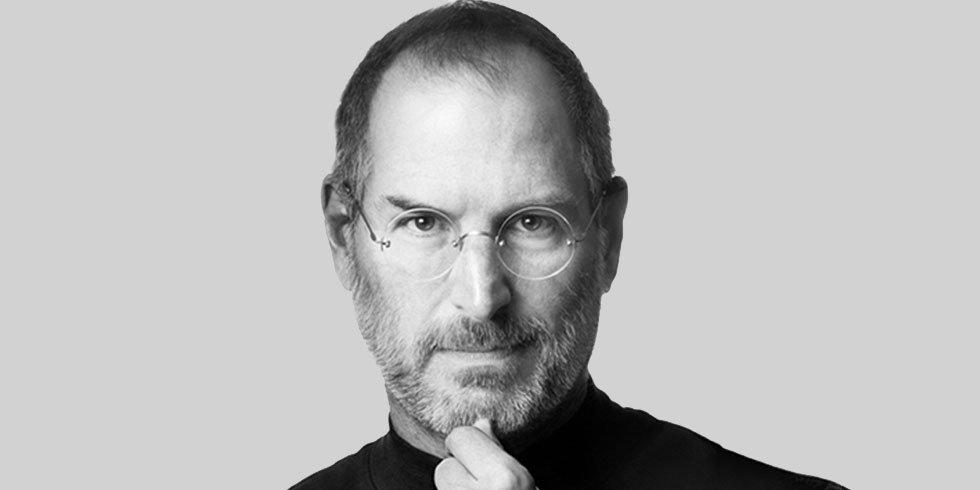

Resultat obtenu :

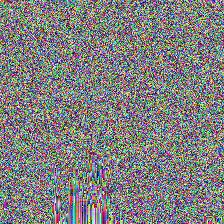

Le résultat obtenu n'est pas concluant, nous avons cherché à savoir pourquoi.

Premièrement, nous avons choisi d'utiliser le modèle pré-entraîné VGG19 au lieu de VGG16, celui conseillé dans le papier. L'hypothèse que ce modèle de ne permet pas de minimiser notre fonction et donc le style n'est pas retenu selon nous.

Deuxièmement, nous n'avons pas le matériel technique afin de pouvoir tester sans retenu nos modèles. La puissance de calcul étant insuffisante, nous n'avons pas pu tester plusieurs optimiseur comme Adam ou SGD ou LBFGS, avec différentes valeurs de taux d'apprentissage (learning rate).
De plus, nous n'avons pas cherché le sur-apprentissage de notre modèle, car une seule époch prend énormément de temps sur nos machines.
En se penchant sur certains articles de blog (comme [celui-ci](https://towardsdatascience.com/perceptual-losses-for-real-time-style-transfer-and-super-resolution-637b5d93fa6d)) nous pouvons dire qu'il serait peut-être nécessaire de faire 40 000 itérations, au minimun, afin d'obtenir des résultats.

En essayant d'implémenter un modèle dans l'air du temps, nous avons dû faire face aux difficultés du Deep Learning, c'est-à-dire la puissance de calcul.

## « Arbitrary Style Transfer »

Nous avons quand meme continué les recherches en cherchant les implémentations les plus performantes aujourd'hui.
Un modèle qui permettrait de faire n'importe quel style sans avoir un modèle pré entrainé.

- [« Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization »](https://arxiv.org/abs/1703.06868)
- [« Exploring the structure of a real-time, arbitrary neural artistic stylization network »](https://arxiv.org/abs/1705.06830)

Ce modèle est le plus complexe. Il permet d’appliquer n’importe quel style pour un content avec un seul modèle.

La structure est la suivante :

- Un réseau de transfer de style 
- Un réseau permettant de calculer la loss
- Un réseau de prédiction sur le style choisi

Ce modèle fonctionne comme celui du dessus, simplement le réseau de prédiction de style va permettre au modèle de comprendre le style demandé et de l’envoyer directement dans le réseau qui fera le transfer.

Il demande donc beaucoup de temps de calcul, ainsi qu’une capacité de stockage importante, car il faut à la fois pourvoir entrainer le modèle pour le transfer de style mais également le modèle pour le prédiction du style.


**Bibliographie :**


1. Leon A. Gatys, Alexander S. Ecker, Matthias Bethge. "A Neural Algorithm of Artistic Style". https://arxiv.org/abs/1508.06576
2. Justin Johnson, Alexandre Alahi, Li Fei-Fei. "Perceptual Losses for Real-Time Style Transfer and Super-Resolution". https://arxiv.org/abs/1603.08155
3. Xun Huang, Serge Belongie. "Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization". https://arxiv.org/abs/1703.06868
4. Golnaz Ghiasi, Honglak Lee, Manjunath Kudlur, Vincent Dumoulin, Jonathon Shlens. "Exploring the structure of a real-time, arbitrary neural artistic stylization network". https://arxiv.org/abs/1705.06830
5. François Pachet. "Style transfert full Architecture process"
6. Alec Radford, Luke Metz, Soumith Chintala. "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" https://arxiv.org/abs/1511.06434